In [1]:
import copy
import math
import warnings
from typing import Optional, Tuple, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.checkpoint import checkpoint

In [2]:
class SwitchTransformersTop1Router(nn.Module):
    """
    Router using tokens choose top-1 experts assignment.
    This router uses the same mechanism as in Switch Transformer (https://arxiv.org/abs/2101.03961) and V-MoE
    (https://arxiv.org/abs/2106.05974): tokens choose their top experts. Items are sorted by router_probs and then
    routed to their choice of expert until the expert's expert_capacity is reached. **There is no guarantee that each
    token is processed by an expert**, or that each expert receives at least one token.
    """

    def __init__(self, hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, router_ignore_padding_tokens, router_dtype):
        super().__init__()
        self.num_experts = num_experts
        self.expert_capacity = experts_capacity
        self.classifier = nn.Linear(hidden_size, num_experts, bias=router_bias)
        self.jitter_noise = router_jitter_noise
        self.ignore_padding_tokens = router_ignore_padding_tokens
        self.dtype = getattr(torch, router_dtype)

    def _compute_router_probabilities(self, hidden_states: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        r"""
        Computes router probabilities from input hidden states.
        Args:
            hidden_states (`torch.Tensor`):
                (batch_size, sequence_length, hidden_dim) from which router probabilities are computed.
        Returns:
            router_probabilities (`torch.Tensor`):
                Tensor of shape (batch_size, sequence_length, num_experts) corresponding to the probabilities for each
                token and expert. Used for routing tokens to experts.
            router_logits (`torch.Tensor`):
                Logits tensor of shape (batch_size, sequence_length, num_experts) corresponding to raw router logits.
                This is used later for computing router z-loss.
        """
        # float32 is used to ensure stability. See the discussion of "selective precision" in
        # https://arxiv.org/abs/2101.03961.
        # We also store the previous dtype to cast back the output to the previous dtype
        self.input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(self.dtype)

        if self.jitter_noise > 0:
            # Get the lower and upper bound of the uniform distribution
            # Adapted from: https://stackoverflow.com/questions/44328530/how-to-get-a-uniform-distribution-in-a-range-r1-r2-in-pytorch
            distrib_lower_bound = 1.0 - self.jitter_noise
            distrib_upper_bound = 1.0 + self.jitter_noise

            uniform_distrib = torch.rand(hidden_states.shape, device=hidden_states.device, dtype=self.dtype)
            uniform_distrib = uniform_distrib * (distrib_lower_bound - distrib_upper_bound)

            uniform_distrib = uniform_distrib + distrib_upper_bound
            # Multiply the token inputs by the uniform distribution - adding some noise
            hidden_states *= uniform_distrib

        # Shape: [num_groups, tokens_per_group, num_experts]
        self._cast_classifier()
        router_logits = self.classifier(hidden_states)

        # Apply Softmax and cast back to the original `dtype`
        router_probabilities = nn.functional.softmax(router_logits, dim=-1, dtype=self.dtype).to(self.input_dtype)
        return router_probabilities, router_logits

    def _cast_classifier(self):
        r"""
        `bitsandbytes` `Linear8bitLt` layers does not support manual casting Therefore we need to check if they are an
        instance of the `Linear8bitLt` class by checking special attributes.
        """
        if not (hasattr(self.classifier, "SCB") or hasattr(self.classifier, "CB")):
            self.classifier = self.classifier.to(self.dtype)

    def forward(self, hidden_states: torch.Tensor) -> Tuple:
        r"""
        Generic forward function for every Router class. Each Router expects to have the same input hidden states
        (`hidden_states`) corresponding to the hidden states for each token, the `expert_capacity` corresponding to the
        number of tokens the Router will send to each expert, some Routers can send up to few tokens to each expert.
        Each Router works as the following: it expects the hidden states for each token, gets the `router_probs` and
        `router_logits` from the `router_weights`. This will assign for each token, the raw probability to be assigned
        to an expert. Then each Router class will have to define its own `_compute_routing_instructions`.
        Args:
            hidden_states (`torch.Tensor`) :
                [num_groups, tokens_per_group, hidden_dim] inputs to send to experts.
        Returns:
            Tuple[`torch.Tensor`, `torch.Tensor`, `torch.Tensor`] Tuple containing the expert index, the router probs
            and the router logits. The router probabilities and logits are required to compute the loss.
        """
        router_probs, router_logits = self._compute_router_probabilities(hidden_states)

        expert_index = torch.argmax(router_probs, dim=-1)
        expert_index = torch.nn.functional.one_hot(expert_index, num_classes=self.num_experts)

        # Mask tokens outside expert capacity. Sum over each sequence
        token_priority = torch.cumsum(expert_index, dim=-2)
        # mask if the token routed to to the expert will overflow
        expert_capacity_mask = token_priority <= self.expert_capacity
        expert_index = expert_index * expert_capacity_mask

        router_probs = torch.max(router_probs, dim=-1).values.unsqueeze(-1)
        return expert_index, router_probs, router_logits

In [3]:
class SwitchTransformersLayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        """
        Construct a layernorm module in the SwitchTransformers style. No bias and no subtraction of mean.
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        # SwitchTransformers uses a layer_norm which only scales and doesn't shift, which is also known as Root Mean
        # Square Layer Normalization https://arxiv.org/abs/1910.07467 thus varience is calculated
        # w/o mean and there is no bias. Additionally we want to make sure that the accumulation for
        # half-precision inputs is done in fp32

        variance = hidden_states.to(torch.float32).pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)

        # convert into half-precision if necessary
        if self.weight.dtype in [torch.float16, torch.bfloat16]:
            hidden_states = hidden_states.to(self.weight.dtype)

        return self.weight * hidden_states

In [4]:
class SwitchTransformersDenseActDense(nn.Module):
    def __init__(self, d_model, d_ff, dropout_rate, dense_act_fn):
        super().__init__()
        self.wi = nn.Linear(d_model, d_ff, bias=False)
        self.wo = nn.Linear(d_ff, d_model, bias=False)
        self.dropout = nn.Dropout(dropout_rate)
        if dense_act_fn == "gelu":
            self.act = nn.GELU()

    def forward(self, hidden_states):
        hidden_states = self.wi(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.dropout(hidden_states)
        if (
            isinstance(self.wo.weight, torch.Tensor)
            and hidden_states.dtype != self.wo.weight.dtype
            and self.wo.weight.dtype != torch.int8
        ):
            hidden_states = hidden_states.to(self.wo.weight.dtype)
        hidden_states = self.wo(hidden_states)
        return hidden_states

In [5]:
class SwitchTransformersDenseGatedActDense(nn.Module):
    def __init__(self, d_model, d_ff, dropout_rate, dense_act_fn):
        super().__init__()
        self.wi_0 = nn.Linear(d_model, d_ff, bias=False)
        self.wi_1 = nn.Linear(d_model, d_ff, bias=False)
        self.wo = nn.Linear(d_ff, d_model, bias=False)
        self.dropout = nn.Dropout(dropout_rate)
        if dense_act_fn == "gelu":
            self.act = nn.GELU()

    def forward(self, hidden_states):
        hidden_gelu = self.act(self.wi_0(hidden_states))
        hidden_linear = self.wi_1(hidden_states)
        hidden_states = hidden_gelu * hidden_linear
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.wo(hidden_states)
        return hidden_states


In [6]:
class SwitchTransformersSparseMLP(nn.Module):
    r"""
    Implementation of the Switch Transformers Sparse MLP module.
    """

    def __init__(self, hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, router_ignore_padding_tokens, 
                 router_dtype, d_model, d_ff, dropout_rate, dense_act_fn, expert_class: nn.Module = SwitchTransformersDenseActDense):        
        super().__init__()
        # Step 1: Get the correct router according to its class
        self.router = SwitchTransformersTop1Router(hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, 
                                                   router_ignore_padding_tokens, router_dtype)

        # Step 2: Get the experts
        self.experts = nn.ModuleDict()
        for idx in range(num_experts):
            self.experts[f"expert_{idx}"] = expert_class(d_model, d_ff, dropout_rate, dense_act_fn)

    def forward(self, hidden_states):
        r"""
        Hold on, this will be slightly tricky to understand In the correct order, a MoE layer does the following:
        1- Gets the `router_mask` from the router. The shape of the mask is `(batch_size, sequence_length, num_expert)`
        and corresponds to the argmax of the `router_probs`. The probabilities are needed in the computation of the
        hidden states : they are broadcasted to the hidden states values (can be interpreted as a scaling factor).
        2- Dispatch the tokens to its associated experts. We do a classic for loop over the experts and assign for each
        expert the corresponding hidden states.
        """
        # Step 1: Get the router_mask from the router as wel as the probabilities
        router_mask, router_probs, router_logits = self.router(hidden_states)
        expert_index = torch.argmax(router_mask, dim=-1)

        # The routers introduced might not always map all the tokens, to a router, which means that some hidden states
        # can be unchanged from one layer to another. That is why the hidden states are cloned before updating only the seleced ones.

        next_states = hidden_states.clone()
        for idx, expert in enumerate(self.experts.values()):
            token_indices = router_mask[:, :, idx].bool()
            next_states[token_indices] = expert(hidden_states[token_indices])

        hidden_states = router_probs * next_states
        return hidden_states, (router_logits, expert_index)

In [7]:
class SwitchTransformersLayerFF(nn.Module):
    r"""
    Switch Transformers Feed Forward layer module. This is a wrapper around the Mixture of Experts module.
    Parameters:
        config : ([`SwitchTransformersConfig`]): Model configuration class with all the parameters of the model.
            Initializing with a config file does not load the weights associated with the model, only the
            configuration. Check out the [`~PreTrainedModel.from_pretrained`] method to load the model weights.
        is_sparse (`bool`):
            Whether the MLP layer is a `Sparse` layer (contains a Mixture of Experts) or not
    """

    def __init__(self, hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, router_ignore_padding_tokens, 
                 router_dtype, d_model, d_ff, dropout_rate, dense_act_fn, layer_norm_epsilon, is_sparse=False):
        super().__init__()
        self.is_sparse = is_sparse

        # Check if it is a sparse layer, if not then it is a dense layer
        if not self.is_sparse:
            self.mlp = SwitchTransformersDenseActDense(d_model, d_ff, dropout_rate, dense_act_fn)
        else:
            self.mlp = SwitchTransformersSparseMLP(hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, 
                 router_ignore_padding_tokens, router_dtype, d_model, d_ff, dropout_rate, dense_act_fn)

        self.layer_norm = SwitchTransformersLayerNorm(d_model, eps=layer_norm_epsilon)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, hidden_states, output_router_logits):
        forwarded_states = self.layer_norm(hidden_states)
        forwarded_states = self.mlp(forwarded_states)

        if isinstance(forwarded_states, tuple):
            forwarded_states, router_tuple = forwarded_states
        else:
            router_tuple = None

        output = hidden_states + self.dropout(forwarded_states)

        if output_router_logits and router_tuple is not None:
            output = (output, router_tuple)
        return output

In [8]:
class SwitchTransformersAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, relative_attention_max_distance, 
                 is_decoder=False, has_relative_attention_bias=False):
        super().__init__()
        self.is_decoder = is_decoder
        self.has_relative_attention_bias = has_relative_attention_bias
        self.relative_attention_num_buckets = relative_attention_num_buckets
        self.relative_attention_max_distance = relative_attention_max_distance
        self.d_model = d_model
        self.key_value_proj_dim = d_kv
        self.n_heads = num_heads
        self.dropout = dropout_rate
        self.inner_dim = self.n_heads * self.key_value_proj_dim

        # Mesh TensorFlow initialization to avoid scaling before softmax
        self.q = nn.Linear(self.d_model, self.inner_dim, bias=False)
        self.k = nn.Linear(self.d_model, self.inner_dim, bias=False)
        self.v = nn.Linear(self.d_model, self.inner_dim, bias=False)
        self.o = nn.Linear(self.inner_dim, self.d_model, bias=False)

        if self.has_relative_attention_bias:
            self.relative_attention_bias = nn.Embedding(self.relative_attention_num_buckets, self.n_heads)
        self.pruned_heads = set()
        self.gradient_checkpointing = False

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.n_heads, self.key_value_proj_dim, self.pruned_heads
        )
        # Prune linear layers
        self.q = prune_linear_layer(self.q, index)
        self.k = prune_linear_layer(self.k, index)
        self.v = prune_linear_layer(self.v, index)
        self.o = prune_linear_layer(self.o, index, dim=1)
        # Update hyper params
        self.n_heads = self.n_heads - len(heads)
        self.inner_dim = self.key_value_proj_dim * self.n_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    @staticmethod
    def _relative_position_bucket(relative_position, bidirectional=True, num_buckets=32, max_distance=128):
        """
        Adapted from Mesh Tensorflow:
        https://github.com/tensorflow/mesh/blob/0cb87fe07da627bf0b7e60475d59f95ed6b5be3d/mesh_tensorflow/transformer/transformer_layers.py#L593
        Translate relative position to a bucket number for relative attention. The relative position is defined as
        memory_position - query_position, i.e. the distance in tokens from the attending position to the attended-to
        position. If bidirectional=False, then positive relative positions are invalid. We use smaller buckets for
        small absolute relative_position and larger buckets for larger absolute relative_positions. All relative
        positions >=max_distance map to the same bucket. All relative positions <=-max_distance map to the same bucket.
        This should allow for more graceful generalization to longer sequences than the model has been trained on
        Args:
            relative_position: an int32 Tensor
            bidirectional: a boolean - whether the attention is bidirectional
            num_buckets: an integer
            max_distance: an integer
        Returns:
            a Tensor with the same shape as relative_position, containing int32 values in the range [0, num_buckets)
        """
        relative_buckets = 0
        if bidirectional:
            num_buckets //= 2
            relative_buckets += (relative_position > 0).to(torch.long) * num_buckets
            relative_position = torch.abs(relative_position)
        else:
            relative_position = -torch.min(relative_position, torch.zeros_like(relative_position))
        # now relative_position is in the range [0, inf)

        # half of the buckets are for exact increments in positions
        max_exact = num_buckets // 2
        is_small = relative_position < max_exact

        # The other half of the buckets are for logarithmically bigger bins in positions up to max_distance
        relative_position_if_large = max_exact + (
            torch.log(relative_position.float() / max_exact)
            / math.log(max_distance / max_exact)
            * (num_buckets - max_exact)
        ).to(torch.long)
        relative_position_if_large = torch.min(
            relative_position_if_large, torch.full_like(relative_position_if_large, num_buckets - 1)
        )

        relative_buckets += torch.where(is_small, relative_position, relative_position_if_large)
        return relative_buckets

    def compute_bias(self, query_length, key_length, device=None):
        """Compute binned relative position bias"""
        if device is None:
            device = self.relative_attention_bias.weight.device
        context_position = torch.arange(query_length, dtype=torch.long, device=device)[:, None]
        memory_position = torch.arange(key_length, dtype=torch.long, device=device)[None, :]
        relative_position = memory_position - context_position  # shape (query_length, key_length)
        relative_position_bucket = self._relative_position_bucket(
            relative_position,  # shape (query_length, key_length)
            bidirectional=(not self.is_decoder),
            num_buckets=self.relative_attention_num_buckets,
            max_distance=self.relative_attention_max_distance,
        )
        values = self.relative_attention_bias(relative_position_bucket)  # shape (query_length, key_length, num_heads)
        values = values.permute([2, 0, 1]).unsqueeze(0)  # shape (1, num_heads, query_length, key_length)
        return values

    def forward(
        self,
        hidden_states,
        mask=None,
        key_value_states=None,
        position_bias=None,
        past_key_value=None,
        layer_head_mask=None,
        query_length=None,
        use_cache=False,
        output_attentions=False,
    ):
        """
        Self-attention (if key_value_states is None) or attention over source sentence (provided by key_value_states).
        """
        # Input is (batch_size, seq_length, dim)
        # Mask is (batch_size, key_length) (non-causal) or (batch_size, key_length, key_length)
        # past_key_value[0] is (batch_size, n_heads, q_len - 1, dim_per_head)
        batch_size, seq_length = hidden_states.shape[:2]

        real_seq_length = seq_length

        if past_key_value is not None:
            assert (
                len(past_key_value) == 2
            ), f"past_key_value should have 2 past states: keys and values. Got { len(past_key_value)} past states"
            real_seq_length += past_key_value[0].shape[2] if query_length is None else query_length

        key_length = real_seq_length if key_value_states is None else key_value_states.shape[1]

        def shape(states):
            """projection"""
            return states.view(batch_size, -1, self.n_heads, self.key_value_proj_dim).transpose(1, 2)

        def unshape(states):
            """reshape"""
            return states.transpose(1, 2).contiguous().view(batch_size, -1, self.inner_dim)

        def project(hidden_states, proj_layer, key_value_states, past_key_value):
            """projects hidden states correctly to key/query states"""
            if key_value_states is None:
                # self-attn
                # (batch_size, n_heads, seq_length, dim_per_head)
                hidden_states = shape(proj_layer(hidden_states))
            elif past_key_value is None:
                # cross-attn
                # (batch_size, n_heads, seq_length, dim_per_head)
                hidden_states = shape(proj_layer(key_value_states))
            if past_key_value is not None:
                if key_value_states is None:
                    # self-attn
                    # (batch_size, n_heads, key_length, dim_per_head)
                    hidden_states = torch.cat([past_key_value, hidden_states], dim=2)
                elif past_key_value.shape[2] != key_value_states.shape[1]:
                    # checking that the `sequence_length` of the `past_key_value` is the same as
                    # the provided `key_value_states` to support prefix tuning
                    # cross-attn
                    # (batch_size, n_heads, seq_length, dim_per_head)
                    hidden_states = shape(proj_layer(key_value_states))
                else:
                    # cross-attn
                    hidden_states = past_key_value
            return hidden_states

        # get query states
        query_states = shape(self.q(hidden_states))  # (batch_size, n_heads, seq_length, dim_per_head)

        # get key/value states
        key_states = project(
            hidden_states, self.k, key_value_states, past_key_value[0] if past_key_value is not None else None
        )
        value_states = project(
            hidden_states, self.v, key_value_states, past_key_value[1] if past_key_value is not None else None
        )

        # compute scores
        scores = torch.matmul(
            query_states, key_states.transpose(3, 2)
        )  # equivalent of torch.einsum("bnqd,bnkd->bnqk", query_states, key_states), compatible with onnx op>9

        if position_bias is None:
            if not self.has_relative_attention_bias:
                position_bias = torch.zeros(
                    (1, self.n_heads, real_seq_length, key_length), device=scores.device, dtype=scores.dtype
                )
                if self.gradient_checkpointing and self.training:
                    position_bias.requires_grad = True
            else:
                position_bias = self.compute_bias(real_seq_length, key_length, device=scores.device)

            # if key and values are already calculated
            # we want only the last query position bias
            if past_key_value is not None:
                position_bias = position_bias[:, :, -hidden_states.size(1) :, :]

            if mask is not None:
                position_bias = position_bias + mask  # (batch_size, n_heads, seq_length, key_length)

        if self.pruned_heads:
            mask = torch.ones(position_bias.shape[1])
            mask[list(self.pruned_heads)] = 0
            position_bias_masked = position_bias[:, mask.bool()]
        else:
            position_bias_masked = position_bias

        scores += position_bias_masked
        attn_weights = nn.functional.softmax(scores.float(), dim=-1).type_as(
            scores
        )  # (batch_size, n_heads, seq_length, key_length)
        attn_weights = nn.functional.dropout(
            attn_weights, p=self.dropout, training=self.training
        )  # (batch_size, n_heads, seq_length, key_length)

        # Mask heads if we want to
        if layer_head_mask is not None:
            attn_weights = attn_weights * layer_head_mask

        attn_output = unshape(torch.matmul(attn_weights, value_states))  # (batch_size, seq_length, dim)
        attn_output = self.o(attn_output)

        present_key_value_state = (key_states, value_states) if (self.is_decoder and use_cache) else None
        outputs = (attn_output,) + (present_key_value_state,) + (position_bias,)

        if output_attentions:
            outputs = outputs + (attn_weights,)
        return outputs

In [9]:
class SwitchTransformersLayerSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, relative_attention_max_distance, 
                 layer_norm_epsilon=1e-6, is_decoder=False, has_relative_attention_bias=False):
        super().__init__()
        self.SelfAttention = SwitchTransformersAttention(
            d_model=d_model, num_heads=num_heads, dropout_rate=dropout_rate, d_kv=d_kv, 
            relative_attention_num_buckets=relative_attention_num_buckets, relative_attention_max_distance=relative_attention_max_distance, 
            is_decoder=is_decoder, has_relative_attention_bias=has_relative_attention_bias
        )
        self.layer_norm = SwitchTransformersLayerNorm(d_model, layer_norm_epsilon)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        position_bias=None,
        layer_head_mask=None,
        past_key_value=None,
        use_cache=False,
        output_attentions=False,
    ):
        normed_hidden_states = self.layer_norm(hidden_states)
        attention_output = self.SelfAttention(
            normed_hidden_states,
            mask=attention_mask,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=past_key_value,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        hidden_states = hidden_states + self.dropout(attention_output[0])
        outputs = (hidden_states,) + attention_output[1:]  # add attentions if we output them
        return outputs

In [10]:
class SwitchTransformersLayerCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, relative_attention_max_distance, 
                 layer_norm_epsilon, is_decoder=False, has_relative_attention_bias=False):
        super().__init__()
        self.EncDecAttention = SwitchTransformersAttention(d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, 
                 relative_attention_max_distance, is_decoder, has_relative_attention_bias)
        self.layer_norm = SwitchTransformersLayerNorm(d_model, eps=layer_norm_epsilon)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(
        self,
        hidden_states,
        key_value_states,
        attention_mask=None,
        position_bias=None,
        layer_head_mask=None,
        past_key_value=None,
        use_cache=False,
        query_length=None,
        output_attentions=False,
    ):
        normed_hidden_states = self.layer_norm(hidden_states)
        attention_output = self.EncDecAttention(
            normed_hidden_states,
            mask=attention_mask,
            key_value_states=key_value_states,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=past_key_value,
            use_cache=use_cache,
            query_length=query_length,
            output_attentions=output_attentions,
        )
        layer_output = hidden_states + self.dropout(attention_output[0])
        outputs = (layer_output,) + attention_output[1:]  # add attentions if we output them
        return outputs

In [11]:
class SwitchTransformersBlock(nn.Module):
    def __init__(self, d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, relative_attention_max_distance, 
                 hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, router_ignore_padding_tokens, 
                 router_dtype, d_ff, dense_act_fn, layer_norm_epsilon, is_decoder=False, has_relative_attention_bias=False, is_sparse=False):
        super().__init__()
        self.is_decoder = is_decoder
        self.is_sparse = is_sparse
        self.layer = nn.ModuleList()
        self.layer.append(
            SwitchTransformersLayerSelfAttention(d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, 
                 relative_attention_max_distance, layer_norm_epsilon, is_decoder, has_relative_attention_bias)
        )
        if self.is_decoder:
            self.layer.append(SwitchTransformersLayerCrossAttention(d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, 
                 relative_attention_max_distance, layer_norm_epsilon, is_decoder, has_relative_attention_bias))

        self.layer.append(SwitchTransformersLayerFF(hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, 
                 router_ignore_padding_tokens, router_dtype, d_model, d_ff, dropout_rate, dense_act_fn, layer_norm_epsilon, self.is_sparse))

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        position_bias=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        encoder_decoder_position_bias=None,
        layer_head_mask=None,
        cross_attn_layer_head_mask=None,
        past_key_value=None,
        use_cache=False,
        output_attentions=False,
        output_router_logits=True,
        return_dict=True,
    ):
        if past_key_value is not None:
            if not self.is_decoder:
                logger.warning("`past_key_values` is passed to the encoder. Please make sure this is intended.")
            expected_num_past_key_values = 2 if encoder_hidden_states is None else 4

            if len(past_key_value) != expected_num_past_key_values:
                raise ValueError(
                    f"There should be {expected_num_past_key_values} past states. "
                    f"{'2 (past / key) for cross attention. ' if expected_num_past_key_values == 4 else ''}"
                    f"Got {len(past_key_value)} past key / value states"
                )

            self_attn_past_key_value = past_key_value[:2]
            cross_attn_past_key_value = past_key_value[2:]
        else:
            self_attn_past_key_value, cross_attn_past_key_value = None, None

        self_attention_outputs = self.layer[0](
            hidden_states,
            attention_mask=attention_mask,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=self_attn_past_key_value,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        hidden_states, present_key_value_state = self_attention_outputs[:2]
        attention_outputs = self_attention_outputs[2:]  # Keep self-attention outputs and relative position weights

        # clamp inf values to enable fp16 training
        if hidden_states.dtype == torch.float16 and torch.isinf(hidden_states).any():
            clamp_value = torch.finfo(hidden_states.dtype).max - 1000
            hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        do_cross_attention = self.is_decoder and encoder_hidden_states is not None
        if do_cross_attention:
            # the actual query length is unknown for cross attention
            # if using past key value states. Need to inject it here
            if present_key_value_state is not None:
                query_length = present_key_value_state[0].shape[2]
            else:
                query_length = None

            cross_attention_outputs = self.layer[1](
                hidden_states,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                position_bias=encoder_decoder_position_bias,
                layer_head_mask=cross_attn_layer_head_mask,
                past_key_value=cross_attn_past_key_value,
                query_length=query_length,
                use_cache=use_cache,
                output_attentions=output_attentions,
            )
            hidden_states = cross_attention_outputs[0]

            # clamp inf values to enable fp16 training
            if hidden_states.dtype == torch.float16 and torch.isinf(hidden_states).any():
                clamp_value = torch.finfo(hidden_states.dtype).max - 1000
                hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

            # Combine self attn and cross attn key value states
            if present_key_value_state is not None:
                present_key_value_state = present_key_value_state + cross_attention_outputs[1]

            # Keep cross-attention outputs and relative position weights
            attention_outputs = attention_outputs + cross_attention_outputs[2:]

        # Apply Feed Forward layer
        hidden_states = self.layer[-1](hidden_states, output_router_logits)

        if isinstance(hidden_states, tuple):
            hidden_states, router_tuple = hidden_states
        else:
            router_tuple = (None,)

        # clamp inf values to enable fp16 training
        if hidden_states.dtype == torch.float16 and torch.isinf(hidden_states).any():
            clamp_value = torch.finfo(hidden_states.dtype).max - 1000
            hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        outputs = (hidden_states,)

        if use_cache:
            outputs = outputs + (present_key_value_state,) + attention_outputs + (router_tuple,)           
        else:
            outputs = outputs + attention_outputs + (router_tuple,)

        return outputs  # hidden-states, present_key_value_states, (self-attention position bias), (self-attention weights), (cross-attention position bias), (cross-attention weights), (router_tuple)

In [12]:
class SwitchTransformersStack(nn.Module):
    def __init__(self, d_model, vocab_size, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, relative_attention_max_distance, 
                 hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, router_ignore_padding_tokens, 
                 router_dtype, d_ff, dense_act_fn, layer_norm_epsilon, decoder_sparse_step, encoder_sparse_step, num_decoder_layers,
                 num_layers, output_attentions, use_cache, output_hidden_states, is_decoder=False, has_relative_attention_bias=False, is_sparse=False, embed_tokens=None):
        super().__init__()

        self.embed_tokens = nn.Embedding(vocab_size, d_model)

        if embed_tokens is not None:
            self.embed_tokens.weight = embed_tokens.weight

        self.is_decoder = is_decoder

        sparse_step = decoder_sparse_step if self.is_decoder else encoder_sparse_step
        num_layers = num_decoder_layers if self.is_decoder else num_layers
        self.block = nn.ModuleList()
        for i in range(num_layers):
            is_sparse = True
            #is_sparse = (i % sparse_step == 1) if sparse_step > 0 else False

            self.block.append(
                SwitchTransformersBlock(d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, 
                 relative_attention_max_distance, hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, 
                 router_ignore_padding_tokens, router_dtype, d_ff, dense_act_fn, layer_norm_epsilon, is_decoder, 
                 has_relative_attention_bias=bool(i == 0), is_sparse=is_sparse)
            )

        self.final_layer_norm = SwitchTransformersLayerNorm(d_model, eps=layer_norm_epsilon)
        self.dropout = nn.Dropout(dropout_rate)

        # Initialize weights and apply final processing

        self.device_map = None
        self.gradient_checkpointing = False
        self.use_cache = use_cache
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        

    def get_input_embeddings(self):
        return self.embed_tokens

    def set_input_embeddings(self, new_embeddings):
        self.embed_tokens = new_embeddings

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        inputs_embeds=None,
        head_mask=None,
        cross_attn_head_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        output_router_logits=True,
        return_dict=None,
    ):
        use_cache = use_cache if use_cache is not None else self.use_cache
           
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if input_ids is not None and inputs_embeds is not None:
            err_msg_prefix = "decoder_" if self.is_decoder else ""
            raise ValueError(
                f"You cannot specify both {err_msg_prefix}input_ids and {err_msg_prefix}inputs_embeds at the same time"
            )
        elif input_ids is not None:
            input_shape = input_ids.size(0), input_ids.size(1)
            input_ids = input_ids.view(input_shape[0], input_shape[1], -1)
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            err_msg_prefix = "decoder_" if self.is_decoder else ""
            raise ValueError(f"You have to specify either {err_msg_prefix}input_ids or {err_msg_prefix}inputs_embeds")

        if inputs_embeds is None:
            if self.embed_tokens is None:
                raise ValueError("You have to initialize the model with valid token embeddings")
            inputs_embeds = input_ids

        batch_size, seq_length = input_shape

        # required mask seq length can be calculated via length of past
        mask_seq_length = past_key_values[0][0].shape[2] + seq_length if past_key_values is not None else seq_length

        if use_cache is True:
            if not self.is_decoder:
                raise ValueError(f"`use_cache` can only be set to `True` if {self} is used as a decoder")

        if attention_mask is None:
            attention_mask = torch.ones(batch_size, mask_seq_length, device=inputs_embeds.device)
        if self.is_decoder and encoder_attention_mask is None and encoder_hidden_states is not None:
            encoder_seq_length = encoder_hidden_states.shape[1]
            encoder_attention_mask = torch.ones(
                batch_size, encoder_seq_length, device=inputs_embeds.device, dtype=torch.long
            )

        # initialize past_key_values with `None` if past does not exist
        if past_key_values is None:
            past_key_values = [None] * len(self.block)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask = None
        #extended_attention_mask = self.get_extended_attention_mask(attention_mask, input_shape)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=inputs_embeds.device)
            encoder_extended_attention_mask = None
            #encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

        # Prepare head mask if needed
        head_mask=None
        #head_mask = self.get_head_mask(head_mask, self.config.num_layers)
        cross_attn_head_mask=None
        #cross_attn_head_mask = self.get_head_mask(cross_attn_head_mask, self.config.num_layers)
        present_key_value_states = () if use_cache else None
        all_hidden_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None
        all_router_probs = () if output_router_logits else None
        all_cross_attentions = () if (output_attentions and self.is_decoder) else None
        position_bias = None
        encoder_decoder_position_bias = None

        hidden_states = self.dropout(inputs_embeds)

        for i, (layer_module, past_key_value) in enumerate(zip(self.block, past_key_values)):
            layer_head_mask = None
            #layer_head_mask = head_mask[i]
            cross_attn_layer_head_mask = None
            #cross_attn_layer_head_mask = cross_attn_head_mask[i]

            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return tuple(module(*inputs, use_cache, output_attentions))

                    return custom_forward

                layer_outputs = checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    extended_attention_mask,
                    position_bias,
                    encoder_hidden_states,
                    encoder_extended_attention_mask,
                    encoder_decoder_position_bias,
                    layer_head_mask,
                    cross_attn_layer_head_mask,
                    None,  # past_key_value is always None with gradient checkpointing
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask=extended_attention_mask,
                    position_bias=position_bias,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_extended_attention_mask,
                    encoder_decoder_position_bias=encoder_decoder_position_bias,
                    layer_head_mask=layer_head_mask,
                    cross_attn_layer_head_mask=cross_attn_layer_head_mask,
                    past_key_value=past_key_value,
                    use_cache=use_cache,
                    output_attentions=output_attentions,
                    output_router_logits=output_router_logits,
                )

            router_probs = layer_outputs[-1]           
            layer_outputs = layer_outputs[:-1]

            # layer_outputs is a tuple with:
            # hidden-states, key-value-states, (self-attention position bias), (self-attention weights), (cross-attention position bias), (cross-attention weights)
            if use_cache is False:
                layer_outputs = layer_outputs[:1] + (None,) + layer_outputs[1:]

            hidden_states, present_key_value_state = layer_outputs[:2]

            # We share the position biases between the layers - the first layer store them
            # layer_outputs = hidden-states, key-value-states (self-attention position bias), (self-attention weights),
            # (cross-attention position bias), (cross-attention weights)
            position_bias = layer_outputs[2]
            if self.is_decoder and encoder_hidden_states is not None:
                encoder_decoder_position_bias = layer_outputs[4 if output_attentions else 3]
            # append next layer key value states
            if use_cache:
                present_key_value_states = present_key_value_states + (present_key_value_state,)

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[3],)
                if self.is_decoder:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[5],)

            if output_router_logits:
                all_router_probs = all_router_probs + (router_probs,)

        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.dropout(hidden_states)
        
        # Add last layer
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:           
            return tuple(
                v
                for v in [
                    hidden_states,
                    present_key_value_states,
                    all_hidden_states,
                    all_attentions,
                    all_cross_attentions,
                    all_router_probs,
                ]
                if v is not None
            )

In [13]:
class SwitchTransformersModel(nn.Module):
    def __init__(self, d_model, vocab_size, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, 
                 relative_attention_max_distance, hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, 
                 router_ignore_padding_tokens, router_dtype, d_ff, dense_act_fn, layer_norm_epsilon, decoder_sparse_step, 
                 encoder_sparse_step, num_decoder_layers, num_layers, num_sparse_encoder_layers):
        super().__init__()
        self.shared = nn.Embedding(vocab_size, d_model)

        self.encoder = SwitchTransformersStack(d_model, vocab_size, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, 
                 relative_attention_max_distance, hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, 
                 router_ignore_padding_tokens, router_dtype, d_ff, dense_act_fn, layer_norm_epsilon, decoder_sparse_step, 
                 encoder_sparse_step, num_decoder_layers, num_layers, output_attentions=True, use_cache=False, output_hidden_states=True, 
                 is_decoder=False, has_relative_attention_bias=True, is_sparse=True, embed_tokens=self.shared)

        self.decoder = SwitchTransformersStack(d_model, vocab_size, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, 
                 relative_attention_max_distance, hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, 
                 router_ignore_padding_tokens, router_dtype, d_ff, dense_act_fn, layer_norm_epsilon, decoder_sparse_step, 
                 encoder_sparse_step, num_decoder_layers, num_layers, output_attentions=True, use_cache=True, output_hidden_states=True, 
                 is_decoder=True, has_relative_attention_bias=True, is_sparse=True, embed_tokens=self.shared)

        # Initialize weights and apply final processing

        # Model parallel
        self.device_map = None
        self.use_cache = True
        self.use_return_dict = False
        self.num_sparse_encoder_layers = num_sparse_encoder_layers
        
        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(d_model, 1)
        

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)
        self.decoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.BoolTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        decoder_head_mask: Optional[torch.FloatTensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        decoder_inputs_embeds: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_router_logits: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.FloatTensor]]:
        r"""
        Returns:
        Example:
        ```python
        >>> from transformers import AutoTokenizer, SwitchTransformersModel
        >>> tokenizer = AutoTokenizer.from_pretrained("google/switch-base-8")
        >>> model = SwitchTransformersModel.from_pretrained("google/switch-base-8")
        >>> input_ids = tokenizer(
        ...     "Studies have been shown that owning a dog is good for you", return_tensors="pt"
        ... ).input_ids  # Batch size 1
        >>> decoder_input_ids = tokenizer("Studies show that", return_tensors="pt").input_ids  # Batch size 1
        >>> # preprocess: Prepend decoder_input_ids with start token which is pad token for SwitchTransformersModel.
        >>> # This is not needed for torch's SwitchTransformersForConditionalGeneration as it does this internally using labels arg.
        >>> decoder_input_ids = model._shift_right(decoder_input_ids)
        >>> # forward pass
        >>> outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
        >>> last_hidden_states = outputs.last_hidden_state
        ```"""
        use_cache = use_cache if use_cache is not None else self.use_cache
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        # FutureWarning: head_mask was separated into two input args - head_mask, decoder_head_mask
        if head_mask is not None and decoder_head_mask is None:
            if self.config.num_layers == self.config.num_decoder_layers:
                warnings.warn(__HEAD_MASK_WARNING_MSG, FutureWarning)
                decoder_head_mask = head_mask

        if (
            output_router_logits
            and self.num_sparse_encoder_layers == 0
            and self.num_sparse_encoder_layers == 0
        ):
            raise ValueError(
                "You asked to return `output_router_logits` but the transformer in dense, and does                    "
                "           not contain any sparse MLP Layers. Set `output_router_logits = False` and restart"
            )
        # Encode if needed (training, first prediction pass)
        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                inputs_embeds=inputs_embeds,
                head_mask=head_mask,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                output_router_logits=output_router_logits,
                return_dict=return_dict,
            )
        elif return_dict and not isinstance(encoder_outputs, MoEModelOutput):
            encoder_outputs = MoEModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
                router_probs=encoder_outputs[3] if len(encoder_outputs) > 3 else None,
            )

        hidden_states = encoder_outputs[0]

        # Decode
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            inputs_embeds=decoder_inputs_embeds,
            past_key_values=past_key_values,
            encoder_hidden_states=hidden_states,
            encoder_attention_mask=attention_mask,
            head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            output_router_logits=output_router_logits,
            return_dict=return_dict,
        )
        output = decoder_outputs[0]
        output = F.relu(self.flatten(output))
        output = self.final_layer(output)
        
        new_output = (output,) + decoder_outputs[1:]

        if not return_dict:
            return new_output

In [14]:
num_layers = 2
num_decoder_layers = 2
vocab_size = 50
num_heads = 2
d_model = 20
d_ff = 64
dropout_rate = 0
d_kv = 32
relative_attention_num_buckets = 32
relative_attention_max_distance = 128
hidden_size = 20
num_experts = 4
experts_capacity = 10
router_bias = True
router_jitter_noise = 0.01
router_ignore_padding_tokens = True
router_dtype = 'float32'
dense_act_fn = 'gelu'
layer_norm_epsilon = 1e-6
decoder_sparse_step = 2
encoder_sparse_step = 2
num_sparse_encoder_layers = 2

input_ids = torch.rand(5, 21, 20)
target_ids = torch.rand(5, 1, 20)

model=SwitchTransformersModel(
        d_model, vocab_size, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, 
        relative_attention_max_distance, hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, 
        router_ignore_padding_tokens, router_dtype, d_ff, dense_act_fn, layer_norm_epsilon, decoder_sparse_step, 
        encoder_sparse_step, num_decoder_layers, num_layers, num_sparse_encoder_layers
)

In [15]:
hidden_states, present_key_value_states, all_hidden_states, all_attentions, all_cross_attentions, all_router_probs = model(input_ids=input_ids, decoder_input_ids=target_ids, output_router_logits=True)
print(hidden_states.shape)
print(hidden_states)

torch.Size([5, 1])
tensor([[ 0.2873],
        [-0.0507],
        [ 0.3121],
        [ 0.1668],
        [-0.0302]], grad_fn=<AddmmBackward0>)


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [17]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)
input

,date,AOAL,AOAR,PITCH,W,MACH,AIRSPD,TEFLAPL,XIDA,T,...,OPR,OTL,OTR,VIBN1L,VIBN1R,VIBN2L,VIBN2R,FE,TMAX,FS
0,0,-10.55,-4.22,-0.53,63901.05853,0.084,56.3,5,6.855,20.50,...,24,110,110,0.03,0.05,0.05,0.05,23995.070700,24572.967483,577.896783
1,1,-9.84,-3.87,-0.53,63900.67347,0.087,58.2,5,6.325,20.50,...,26,110,110,0.03,0.05,0.07,0.05,23453.775200,24572.967483,1119.192283
2,2,-9.14,-3.34,-0.53,63900.23197,0.090,60.1,5,5.710,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22821.215600,24572.967483,1751.751883
3,3,-8.09,-3.87,-0.35,63899.73805,0.093,62.0,5,5.630,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22738.950900,24572.967483,1834.016583
4,4,-7.56,-3.87,-0.35,63899.14333,0.096,63.9,5,5.365,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22464.769900,24572.967483,2108.197583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11519,11544,-2.81,-3.69,-0.70,56378.87869,0.150,56.0,30,3.950,23.75,...,43,98,98,0.09,0.10,0.10,0.05,7668.487126,18764.344514,11095.857388
11520,11545,-2.99,-3.69,-0.88,56378.72144,0.150,52.0,30,4.220,23.75,...,31,98,98,0.10,0.10,0.12,0.07,7393.237132,18764.344514,11371.107383
11521,11546,-2.81,-3.69,-0.88,56378.57427,0.150,49.0,30,4.130,23.75,...,31,98,98,0.13,0.12,0.12,0.09,7484.958267,18764.344514,11279.386247
11522,11547,-2.81,-3.69,-0.70,56378.43517,0.150,46.0,30,3.950,24.00,...,31,97,97,0.13,0.15,0.18,0.09,7652.561590,18764.344514,11111.782924


In [18]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [19]:
df_for_training=df[feature_names].astype(float)

In [20]:
df_for_training.shape

(11524, 22)

In [21]:
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [22]:
trainX=[]
trainY=[]

In [23]:
n_future=1
n_past=20

In [24]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [25]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [26]:
trainX0=np.zeros((trainX.shape[0],22,20))
for i in range(0,trainX.shape[0]):
    trainX0[i]=trainX[i].T
trainX1=np.zeros((trainX.shape[0],21,20))
for i in range(0,trainX.shape[0]):
    trainX1[i]=trainX0[i][0:21,:]
trainX2=np.zeros((trainX.shape[0],1,20))
for i in range(0,trainX.shape[0]):
    trainX2[i]=trainX0[i][21,:]

In [27]:
trainX1_copy,trainX2_copy,trainY_copy=trainX1.copy(),trainX2.copy(),trainY.copy()

In [28]:
def random_shuffle(data1,data2,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data1)
    np.random.seed(randnum)
    np.random.shuffle(data2)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data1,data2,label

In [29]:
data1,data2,label=random_shuffle(trainX1,trainX2,trainY)

In [30]:
# Create a DataLoader for the training data
data1 = torch.from_numpy(data1).float()
data2 = torch.from_numpy(data2).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data1, data2, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()
device = torch.device("cpu")

In [32]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data1, data2, targets) in enumerate(train_loader):
        data1 = data1.to(device=device)
        data2 = data2.to(device=device)
        targets = targets.to(device=device)
        output, present_key_value_states, all_hidden_states, all_attentions, all_cross_attentions, all_router_probs = model(input_ids=data1, decoder_input_ids=data2, output_router_logits=True)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.8093079328536987
Epoch: 1 Loss: 1.148249864578247
Epoch: 2 Loss: 0.06433305144309998
Epoch: 3 Loss: 0.6730219721794128
Epoch: 4 Loss: 0.41886866092681885
Epoch: 5 Loss: 0.8018103241920471
Epoch: 6 Loss: 0.15394283831119537
Epoch: 7 Loss: 0.10315534472465515
Epoch: 8 Loss: 0.14083260297775269
Epoch: 9 Loss: 0.5030076503753662
Epoch: 10 Loss: 0.20733943581581116
Epoch: 11 Loss: 0.13448265194892883
Epoch: 12 Loss: 0.11839621514081955
Epoch: 13 Loss: 0.6104989051818848
Epoch: 14 Loss: 0.3892529308795929
Epoch: 15 Loss: 0.055139172822237015
Epoch: 16 Loss: 0.32503217458724976
Epoch: 17 Loss: 0.1308736503124237
Epoch: 18 Loss: 1.9695549011230469
Epoch: 19 Loss: 0.16541334986686707
Epoch: 20 Loss: 0.7598134875297546
Epoch: 21 Loss: 0.4582280218601227
Epoch: 22 Loss: 0.6607184410095215
Epoch: 23 Loss: 0.20870348811149597
Epoch: 24 Loss: 0.11154915392398834
Epoch: 25 Loss: 0.45063135027885437
Epoch: 26 Loss: 0.14380186796188354
Epoch: 27 Loss: 1.4951159954071045
Epoch: 28 Loss:

Epoch: 226 Loss: 0.13676238059997559
Epoch: 227 Loss: 0.11783357709646225
Epoch: 228 Loss: 0.03944813832640648
Epoch: 229 Loss: 0.192428857088089
Epoch: 230 Loss: 0.1074574887752533
Epoch: 231 Loss: 0.05099894478917122
Epoch: 232 Loss: 0.09389285743236542
Epoch: 233 Loss: 0.6232318878173828
Epoch: 234 Loss: 0.09459133446216583
Epoch: 235 Loss: 0.14363297820091248
Epoch: 236 Loss: 0.17403213679790497
Epoch: 237 Loss: 0.05845581740140915
Epoch: 238 Loss: 0.11127065122127533
Epoch: 239 Loss: 0.1620534360408783
Epoch: 240 Loss: 0.21655209362506866
Epoch: 241 Loss: 0.1674947887659073
Epoch: 242 Loss: 0.153672993183136
Epoch: 243 Loss: 0.1897723376750946
Epoch: 244 Loss: 0.2039402574300766
Epoch: 245 Loss: 0.05051174759864807
Epoch: 246 Loss: 0.24966804683208466
Epoch: 247 Loss: 0.06366603076457977
Epoch: 248 Loss: 0.08280974626541138
Epoch: 249 Loss: 0.07633322477340698
Epoch: 250 Loss: 0.06088804081082344
Epoch: 251 Loss: 0.06532908976078033
Epoch: 252 Loss: 0.10466240346431732
Epoch: 253 

Epoch: 449 Loss: 0.09687129408121109
Epoch: 450 Loss: 0.08442381024360657
Epoch: 451 Loss: 0.052772242575883865
Epoch: 452 Loss: 0.07156907021999359
Epoch: 453 Loss: 0.25847864151000977
Epoch: 454 Loss: 0.08471488952636719
Epoch: 455 Loss: 0.09775541722774506
Epoch: 456 Loss: 0.1307990849018097
Epoch: 457 Loss: 0.5176584124565125
Epoch: 458 Loss: 0.08972346037626266
Epoch: 459 Loss: 0.14992888271808624
Epoch: 460 Loss: 0.1760289967060089
Epoch: 461 Loss: 0.04706466197967529
Epoch: 462 Loss: 0.05434403195977211
Epoch: 463 Loss: 0.06625019758939743
Epoch: 464 Loss: 0.14593683183193207
Epoch: 465 Loss: 0.03526253625750542
Epoch: 466 Loss: 0.08757919073104858
Epoch: 467 Loss: 0.039514489471912384
Epoch: 468 Loss: 0.24583576619625092
Epoch: 469 Loss: 0.14789628982543945
Epoch: 470 Loss: 0.06588129699230194
Epoch: 471 Loss: 0.08690531551837921
Epoch: 472 Loss: 0.21251656115055084
Epoch: 473 Loss: 0.22445231676101685
Epoch: 474 Loss: 0.11273716390132904
Epoch: 475 Loss: 0.054199978709220886
E

Epoch: 672 Loss: 0.14631350338459015
Epoch: 673 Loss: 0.05589237064123154
Epoch: 674 Loss: 0.41983678936958313
Epoch: 675 Loss: 0.04169130697846413
Epoch: 676 Loss: 0.1139734759926796
Epoch: 677 Loss: 0.030671358108520508
Epoch: 678 Loss: 0.05530236288905144
Epoch: 679 Loss: 0.20636746287345886
Epoch: 680 Loss: 0.09931101649999619
Epoch: 681 Loss: 0.0667450949549675
Epoch: 682 Loss: 0.036268141120672226
Epoch: 683 Loss: 0.05553843080997467
Epoch: 684 Loss: 0.05662648007273674
Epoch: 685 Loss: 0.08802854269742966
Epoch: 686 Loss: 0.043859273195266724
Epoch: 687 Loss: 0.0686684176325798
Epoch: 688 Loss: 0.06345637142658234
Epoch: 689 Loss: 0.04076417163014412
Epoch: 690 Loss: 0.07057951390743256
Epoch: 691 Loss: 0.09462833404541016
Epoch: 692 Loss: 0.05591919273138046
Epoch: 693 Loss: 0.1807451844215393
Epoch: 694 Loss: 0.0746125802397728
Epoch: 695 Loss: 0.11390163749456406
Epoch: 696 Loss: 0.06760790944099426
Epoch: 697 Loss: 0.1508379876613617
Epoch: 698 Loss: 0.07966789603233337
Epoc

Epoch: 894 Loss: 0.09704270213842392
Epoch: 895 Loss: 0.022287879139184952
Epoch: 896 Loss: 0.0997827872633934
Epoch: 897 Loss: 0.042692363262176514
Epoch: 898 Loss: 0.06728507578372955
Epoch: 899 Loss: 0.095695361495018
Epoch: 900 Loss: 0.121686652302742
Epoch: 901 Loss: 0.13695138692855835
Epoch: 902 Loss: 0.051498446613550186
Epoch: 903 Loss: 0.07205960154533386
Epoch: 904 Loss: 0.04063580557703972
Epoch: 905 Loss: 0.11610321700572968
Epoch: 906 Loss: 0.04035894200205803
Epoch: 907 Loss: 0.050799254328012466
Epoch: 908 Loss: 0.04907505214214325
Epoch: 909 Loss: 0.035697318613529205
Epoch: 910 Loss: 0.1478690654039383
Epoch: 911 Loss: 0.1593240350484848
Epoch: 912 Loss: 0.0445941686630249
Epoch: 913 Loss: 0.042632702738046646
Epoch: 914 Loss: 0.06231978163123131
Epoch: 915 Loss: 0.21416528522968292
Epoch: 916 Loss: 0.10622606426477432
Epoch: 917 Loss: 0.06914573907852173
Epoch: 918 Loss: 0.07610809803009033
Epoch: 919 Loss: 0.05252814292907715
Epoch: 920 Loss: 0.04543030634522438
Epo

In [33]:
test_data1 = torch.from_numpy(trainX1_copy).float()
test_data2 = torch.from_numpy(trainX2_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data1, test_data2, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [34]:
predictions=[]
for batch_idx, (data1, data2, targets) in enumerate(test_loader):
    data1 = data1.to(device=device)
    data2 = data2.to(device=device)
    output, present_key_value_states, all_hidden_states, all_attentions, all_cross_attentions, all_router_probs=model(input_ids=data1, decoder_input_ids=data2, output_router_logits=True)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [35]:
predictions = np.array(predictions)

In [36]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [37]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

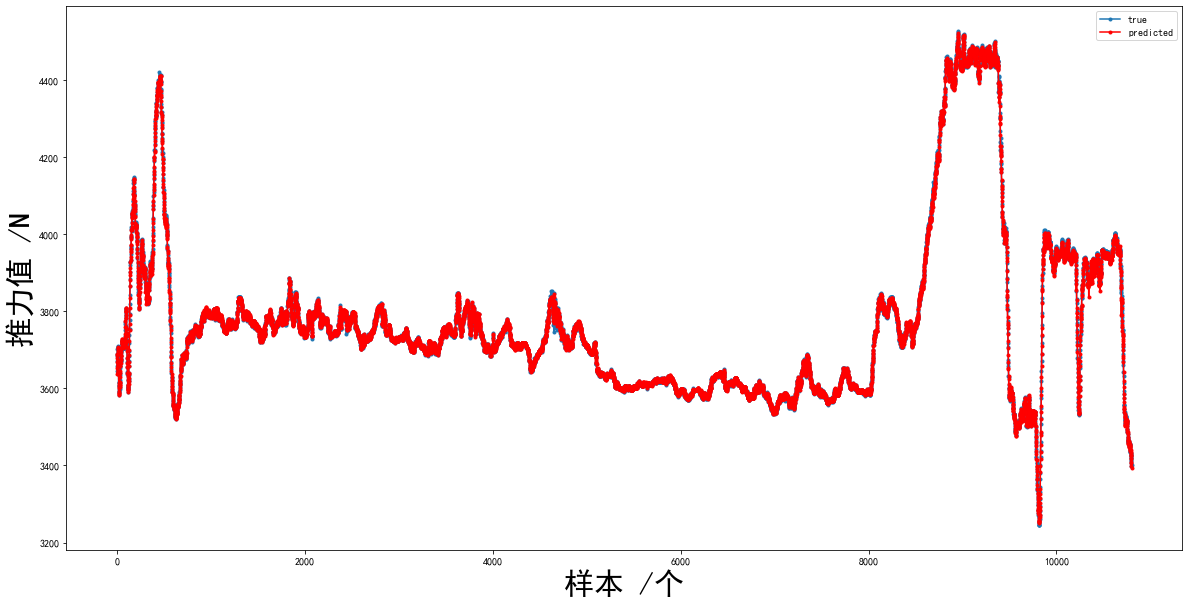

In [38]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();